<a href="https://colab.research.google.com/github/amaye15/CanineNet/blob/main/code/dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torchview mlflow datasets==2.15.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00


In [1]:
import io
import os
import cv2
import datasets
import torch
import torchview
import pyarrow_hotfix
import mlflow
import mlflow.pytorch
import graphviz
import uuid

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim

from PIL import Image
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from datasets import load_dataset, ClassLabel, Value
from functools import partial
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torchview import draw_graph



pyarrow_hotfix.uninstall()
graphviz.set_jupyter_format('png')

os.environ['MLFLOW_TRACKING_USERNAME'] = "andrewmayes14"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "ccb096afadd26486a787461f3495219662998c4b"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "mlflow"

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
                         + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

mlflow.set_experiment("CanineNet")

# Constants
DATASET = "Alanox/stanford-dogs"
REMOVE_COLS_V1 = ["name", "annotations"]
REMOVE_COLS_V2 = ["name", "annotations", "image"]
NAME_COLS = {"index": "label", 0: "count"}
SPLIT = 0.2
IMAGE_SIZE = (256, 256)
OPS = 10

# Load the dataset
dataset = datasets.load_dataset(DATASET, split="full").remove_columns(REMOVE_COLS_V1)# .train_test_split(test_size=SPLIT, stratify_by_column="target") #, streaming=True)

### This is a bit of a work aroound to get even class seperation
target_df = datasets.load_dataset(DATASET, split="full").remove_columns(REMOVE_COLS_V2).to_pandas().value_counts().reset_index().reset_index().rename(columns=NAME_COLS)
# Convert the target column to a list and find unique classes
unique_classes = set(target_df['target'])
# Define the ClassLabel feature
class_label_feature = ClassLabel(num_classes=len(unique_classes), names=list(unique_classes), id = list(range(len(unique_classes))))
# Update the dataset schema to use ClassLabel for the target column
dataset = dataset.cast_column('target', class_label_feature)
###

# Split Dataset
dataset = dataset.train_test_split(test_size=SPLIT, stratify_by_column = "target")



Casting the dataset:   0%|          | 0/20580 [00:00<?, ? examples/s]

In [2]:
# Load the model and the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                  num_labels = len(target_df["label"].tolist()),
                                                  id2label = dict(zip(dataset["train"].features["target"].id, dataset["train"].features["target"].names)),
                                                  label2id = dict(zip(dataset["train"].features["target"].names, dataset["train"].features["target"].id)),
                                                  ignore_mismatched_sizes=True)



/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([120]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([120, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def transforms(examples):
  examples["image"] = [feature_extractor(image, return_tensors = "pt")["pixel_values"].squeeze() for image in examples["image"]]
  return examples

In [4]:
# Start run
run = mlflow.start_run()

# Model Config
# convLayers = [(3, 32, 3, 1, 1)]
# fcLayers = [target_df.shape[0]]
# imageSize = (3, 256, 256)
# dpRates = [0.1]

# Model
# model = CNN(conv_layers = convLayers, fc_layers = fcLayers, input_size = imageSize, dropout_rates = dpRates)
# model_graph = draw_graph(model, input_size=(1, 3, 256, 256), device='meta', roll=True)

# Train Config
EPOCHS = 10
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRANSFORM = True

# Model
# model = CNN(conv_layers = convLayers, fc_layers = fcLayers, input_size = imageSize, dropout_rates = dpRates)
# mlflow.pytorch.log_model(model, "model")

# Criteria & Optimiser
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
num_training_steps = EPOCHS * dataset["train"].num_rows
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_training_steps * 0.01, num_training_steps=num_training_steps)

# Device
model.to(DEVICE)

# Log parameters
mlflow.log_param("epochs", EPOCHS)
mlflow.log_param("learning_rate", LEARNING_RATE)
mlflow.log_param("batch_size", BATCH_SIZE)
# mlflow.log_param("image_transformation", TRANSFORM)
# mlflow.log_param("layers", len(convLayers))

train_step = 0
test_step = 0

dataset.set_transform(transforms)

# Model, Criterion, Optimizer setup remains the same
for epoch in range(EPOCHS):

  # if TRANSFORM:
  #   # Transformation and dataset settings as before
  #   transformation = v2.Compose([v2.RandAugment(num_ops = OPS), v2.Resize(size = IMAGE_SIZE)])
  #   dataset.set_transform(partial(transforms, transformation_function = transformation, to_tensor = True,))
  # else:
  #   # Transformation and dataset settings as before
  #   transformation = v2.Compose([v2.Resize(size = IMAGE_SIZE)])
  #   dataset.set_transform(partial(transforms, transformation_function = transformation, to_tensor = True,))

  # Train
  print("Train")
  model.train()
  for batch in DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True):
      optimizer.zero_grad()
      output = model(batch["image"].float().to(DEVICE))
      loss = criterion(output.logits, batch["target"].to(DEVICE))
      loss.backward()
      optimizer.step()
      scheduler.step()

      train_step += 1

      # Compute training metrics
      train_accuracy = accuracy_score(batch["target"].numpy(), output.logits.argmax(dim=1).cpu().numpy())
      train_precision, train_recall, train_f1, train_support = precision_recall_fscore_support(batch["target"].numpy(),
                                                                                               output.logits.argmax(dim=1).cpu().numpy(),
                                                                                               average='macro',
                                                                                               zero_division = 0.0)
      # print(batch["target"].numpy())
      # print(output.logits.argmax(dim=1).cpu().numpy())

      # Log training metrics
      mlflow.log_metrics({'train_loss': loss.item(),
                          'train_accuracy': train_accuracy,
                          'train_precision': train_precision,
                          'train_recall': train_recall,
                          'train_f1': train_f1,}, step = train_step)

      print({'train_loss': loss.item(),
              'train_accuracy': train_accuracy,
              'train_precision': train_precision,
              'train_recall': train_recall,
              'train_f1': train_f1,})

  # Test
  print("Test")
  model.eval()
  with torch.no_grad():
      for batch in DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False):
          output = model(batch["image"].squeeze(dim=0).float().to(DEVICE))
          loss = criterion(output.logits, batch["target"].to(DEVICE))

          test_step += 1

          # Compute testing metrics
          test_accuracy = accuracy_score(batch["target"].numpy(), output.logits.argmax(dim=1).cpu().numpy())
          test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(batch["target"].numpy(),
                                                                                               output.logits.argmax(dim=1).cpu().numpy(),
                                                                                               average='macro',
                                                                                               zero_division = 0.0)
          # Log testing metrics
          mlflow.log_metrics({'test_loss': loss.item(),
                              'test_accuracy': test_accuracy,
                              'test_precision': test_precision,
                              'test_recall': test_recall,
                              'test_f1': test_f1,}, step = test_step)

          print({'test_loss': loss.item(),
                              'test_accuracy': test_accuracy,
                              'test_precision': test_precision,
                              'test_recall': test_recall,
                              'test_f1': test_f1,})

    # # Log Confusion Matrix as an artifact
    # cm = confusion_matrix(all_test_labels, all_test_preds)
    # plt.figure(figsize=(10,7))
    # #sns.heatmap(cm, annot=True)
    # sns.heatmap(cm, annot=False)
    # plt.xlabel('Predicted')
    # plt.ylabel('Truth')
    # plt.title(f'Confusion Matrix at Epoch {epoch}')
    # plt.savefig("confusion_matrix.png")
    # mlflow.log_artifact("confusion_matrix.png")

# End run
mlflow.end_run()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train
{'train_loss': 4.900509357452393, 'train_accuracy': 0.015625, 'train_precision': 0.0037313432835820895, 'train_recall': 0.014925373134328358, 'train_f1': 0.005970149253731343}
{'train_loss': 4.918637752532959, 'train_accuracy': 0.015625, 'train_precision': 0.013513513513513514, 'train_recall': 0.006756756756756757, 'train_f1': 0.009009009009009009}
{'train_loss': 4.963493824005127, 'train_accuracy': 0.0, 'train_precision': 0.0, 'train_recall': 0.0, 'train_f1': 0.0}
{'train_loss': 5.018585681915283, 'train_accuracy': 0.015625, 'train_precision': 0.006578947368421052, 'train_recall': 0.013157894736842105, 'train_f1': 0.008771929824561403}
{'train_loss': 4.850017070770264, 'train_accuracy': 0.0625, 'train_precision': 0.030516431924882625, 'train_recall': 0.035211267605633804, 'train_f1': 0.03004694835680751}
{'train_loss': 4.943553924560547, 'train_accuracy': 0.0, 'train_precision': 0.0, 'train_recall': 0.0, 'train_f1': 0.0}
{'train_loss': 5.024425983428955, 'train_accuracy': 0.0, '

In [6]:
mlflow.end_run()

In [8]:
  all_test_labels = []
  all_test_preds = []

  model.eval()
  with torch.no_grad():
      for batch in DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False):
          output = model(batch["image"].squeeze(dim=0).float().to(DEVICE))
          all_test_labels.extend(batch["target"].numpy().tolist())
          all_test_preds.extend(output.logits.argmax(dim=1).cpu().numpy().tolist())

In [ ]:
id2labels = dict(zip(dataset["train"].features["target"].id, dataset["train"].features["target"].names))
id2labels

Text(0.5, 1.0, 'Confusion Matrix at Epoch 9')

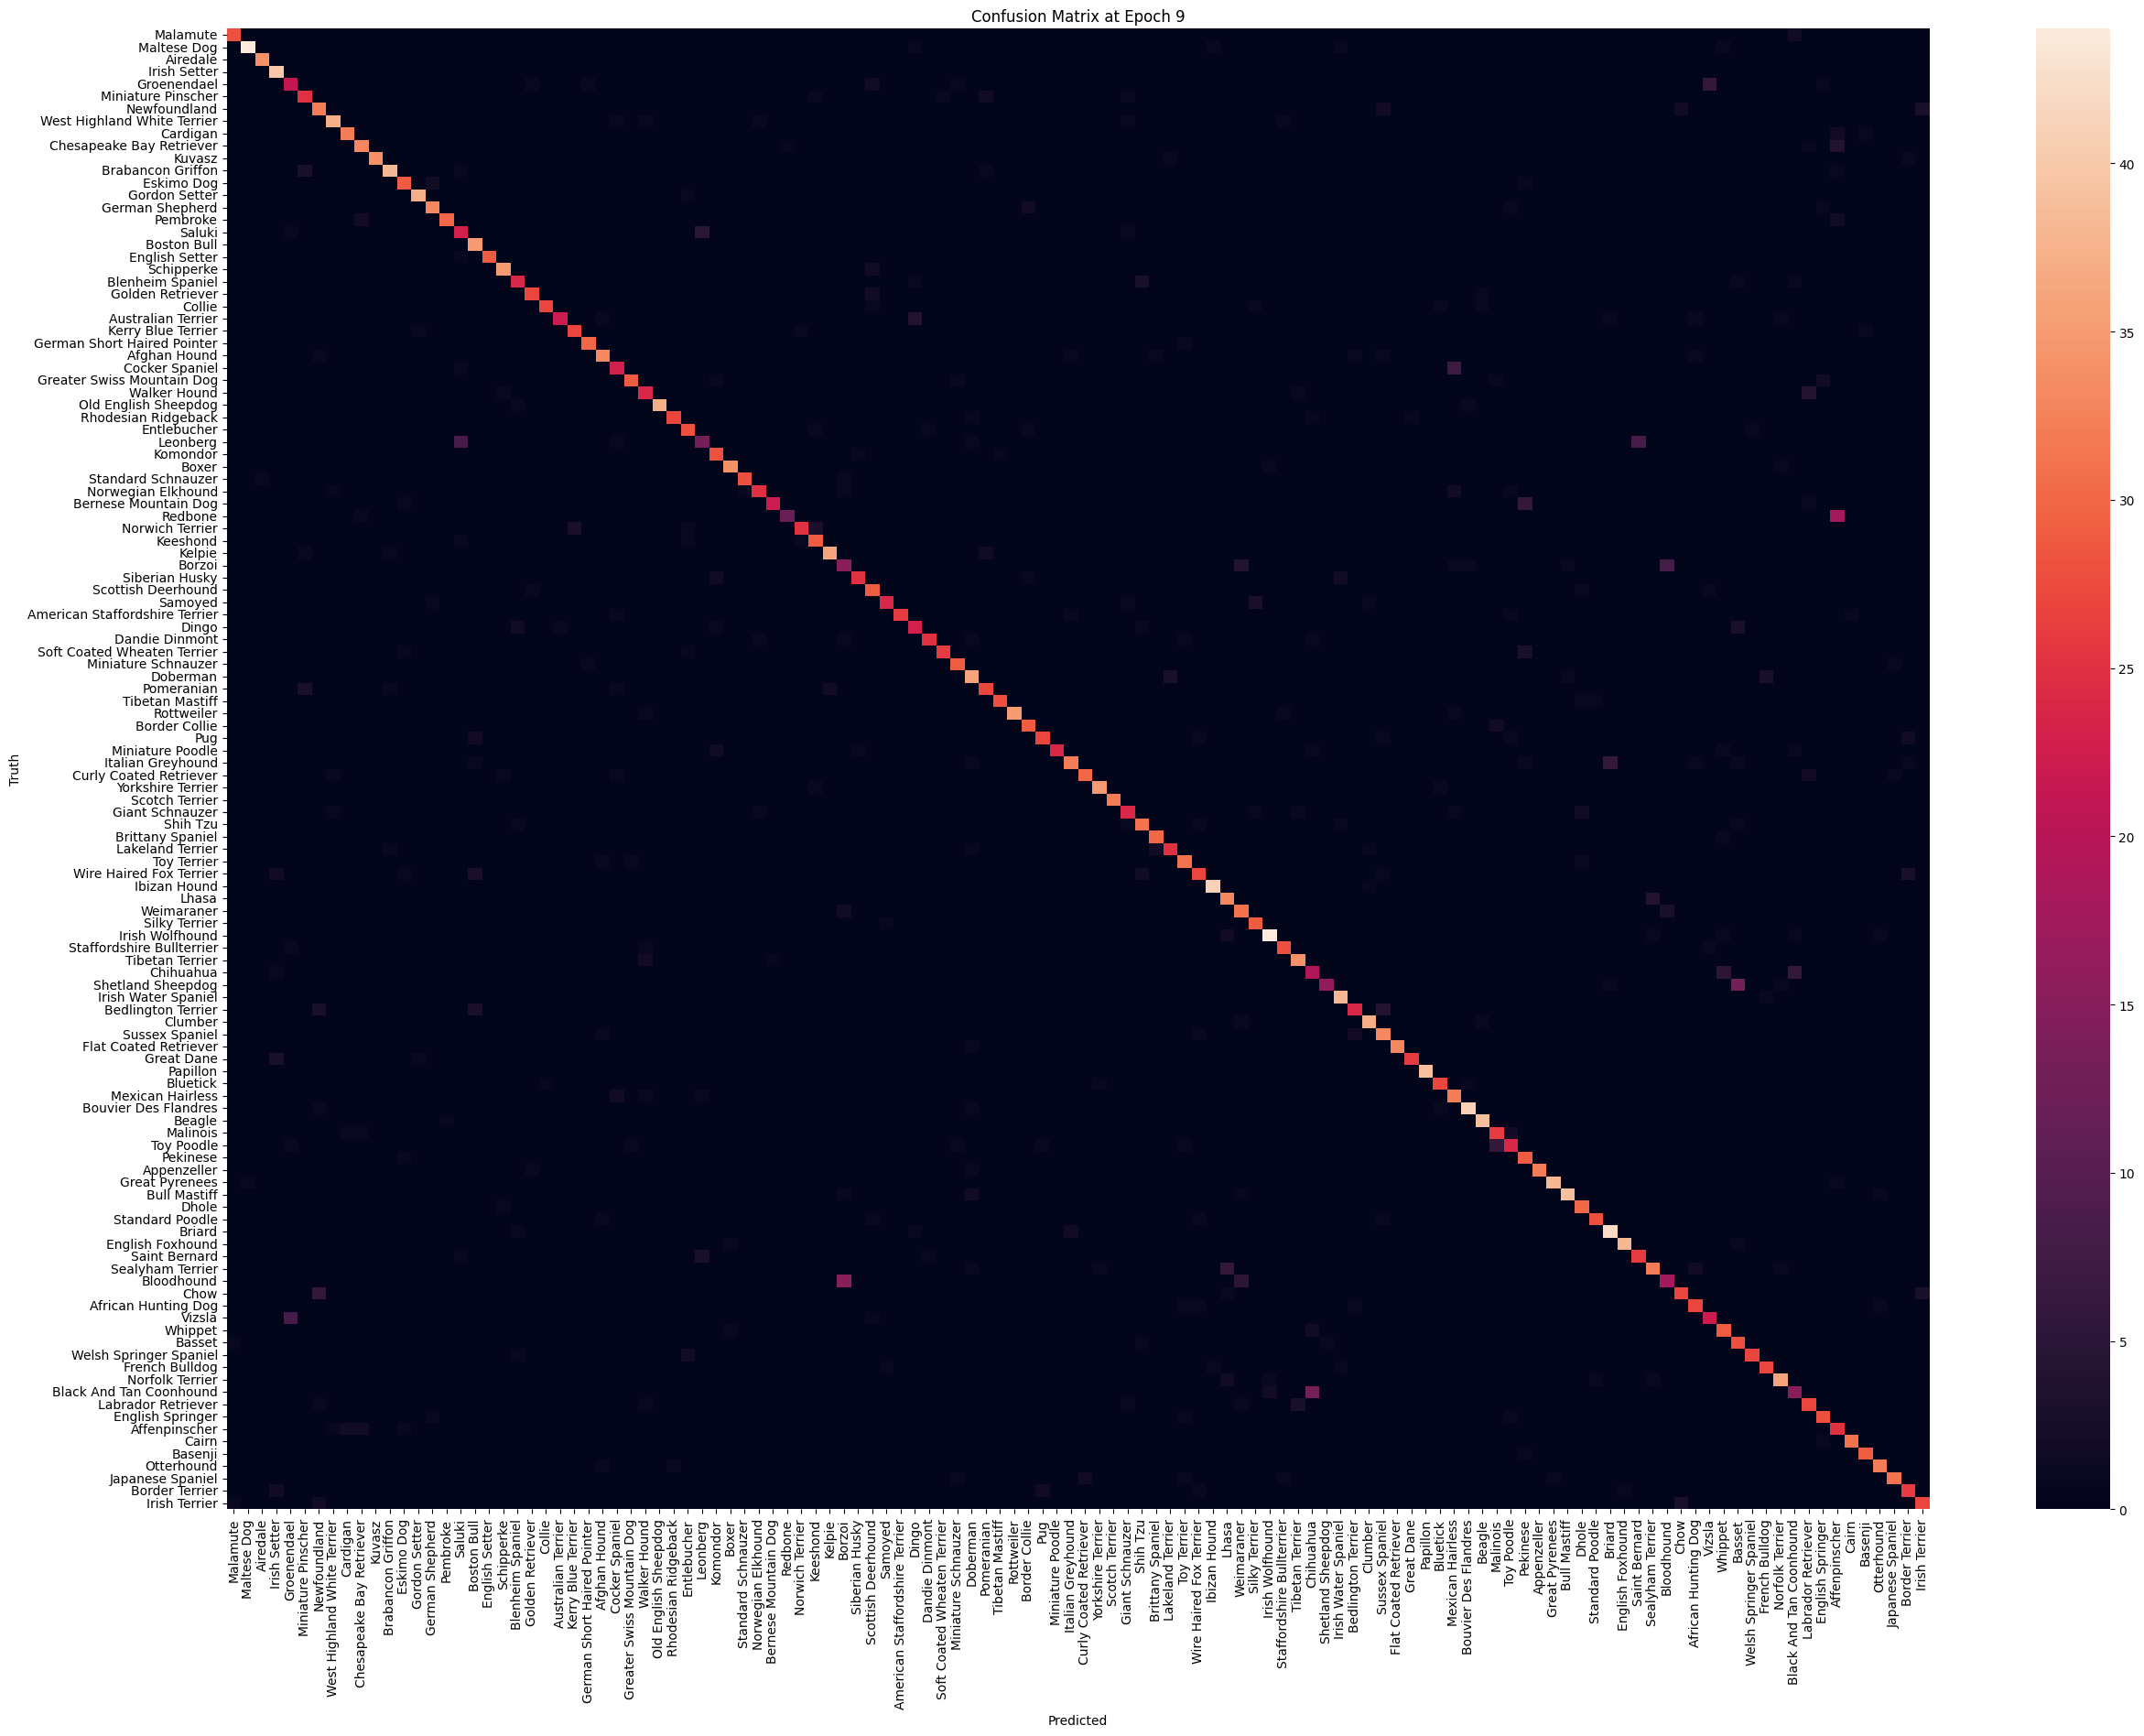

In [15]:
sorted_ids = sorted(id2labels.keys())
class_names = [id2labels[i] for i in sorted_ids]

cm = confusion_matrix([id2labels[i] for i in all_test_labels], [id2labels[i] for i in all_test_preds])
plt.figure(figsize=(30,21))
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title(f'Confusion Matrix at Epoch {epoch}')
#plt.savefig("confusion_matrix.png")
